# Introduction to ptype workflow

Updated by Thomas Martin. This was initially written for interns for the MILES group at NCAR, but can be used for anyone looking to 

Sanity check for GPU access, not necessary for this notebook:

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
import yaml
import numpy as np
import pandas as pd

# Tensorflow imports
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

2023-07-03 12:39:47.042983: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-03 12:39:47.099604: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 12:39:47.861200: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Load in configuration file

In [3]:
config = "../config/ptype.yml"

In [4]:
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [5]:
conf["save_loc"] = "/tmp"

Define input and output features

In [6]:
input_features = conf['TEMP_C'] + conf['T_DEWPOINT_C'] + conf['UGRD_m/s'] + conf['VGRD_m/s']
print('how many input features are we using?', len(input_features))

output_features = conf['ptypes']
print('how many output features are we using?', len(output_features))

#specific features
print('output features:', output_features)

how many input features are we using? 84
how many output features are we using? 4
output features: ['ra_percent', 'sn_percent', 'pl_percent', 'fzra_percent']


### Load data

In [7]:
from ptype.data import load_ptype_uq, preprocess_data

In [8]:
data = load_ptype_uq(conf, data_split=0, verbose=1)
data.keys()

dict_keys(['train', 'val', 'test'])

In [9]:
print('train shape:', data["train"].shape)
print('test  shape:', data["test"].shape)
print('val   shape:', data["val"].shape)

train shape: (742045, 453)
test  shape: (396696, 453)
val   shape: (77367, 453)


In [10]:
scaled_data, scalers = preprocess_data(
        data,
        input_features,
        output_features,
        scaler_type="standard",
        encoder_type="onehot",
        groups=[],
    )

/glade/u/home/tmartin/.conda/envs/ptype2/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


##### Each input column gets transformed into "z-scores"

In [11]:
scaled_data["train_x"].head()

,TEMP_C_0_m,TEMP_C_250_m,TEMP_C_500_m,TEMP_C_750_m,TEMP_C_1000_m,TEMP_C_1250_m,TEMP_C_1500_m,TEMP_C_1750_m,TEMP_C_2000_m,TEMP_C_2250_m,...,VGRD_m/s_2750_m,VGRD_m/s_3000_m,VGRD_m/s_3250_m,VGRD_m/s_3500_m,VGRD_m/s_3750_m,VGRD_m/s_4000_m,VGRD_m/s_4250_m,VGRD_m/s_4500_m,VGRD_m/s_4750_m,VGRD_m/s_5000_m
0,-0.610768,-0.645662,-0.753968,-0.582651,-0.258674,-0.092146,0.050314,0.260894,0.472282,0.603402,...,0.870662,0.545611,0.331951,0.257136,0.232856,0.212132,0.177195,0.136428,0.096277,0.063459
1,-1.544597,-1.597331,-1.707733,-1.896648,-2.124362,-2.190931,-2.248633,-2.259476,-2.219144,-2.151906,...,-1.266968,-1.265000,-1.290175,-1.337132,-1.415796,-1.526929,-1.708339,-1.940517,-2.196968,-2.420509
2,-0.827267,-0.756607,-0.826003,-0.931763,-1.065001,-1.215805,-1.357762,-1.434078,-1.474066,-1.492524,...,-1.548890,-1.557793,-1.524601,-1.453846,-1.379509,-1.342068,-1.353519,-1.399035,-1.465413,-1.534068
3,-0.549342,-0.541780,-0.602278,-0.666170,-0.703255,-0.736447,-0.753797,-0.779801,-0.851306,-0.922395,...,1.737469,1.822353,1.906544,1.976829,2.011894,2.002315,1.971815,1.916722,1.831138,1.738343
4,-0.560459,-0.471010,-0.544565,-0.624629,-0.679935,-0.722399,-0.751941,-0.798688,-0.869158,-0.914975,...,1.717591,1.810358,1.896818,1.965159,1.999938,1.990657,1.947149,1.883099,1.806344,1.712216


##### The precip types are turned into "one-hots"

In [12]:
scaled_data["train_y"]

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

### Load a model

In [13]:
# Create a Sequential model
model = Sequential()

# Add input layer and first hidden layer
model.add(Dense(units=100, activation='relu', input_shape=(len(input_features),)))

# Add second hidden layer
model.add(Dense(units=100, activation='relu'))

# Add output layer
model.add(Dense(units=len(output_features), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               8500      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 4)                 404       
                                                                 
Total params: 19,004
Trainable params: 19,004
Non-trainable params: 0
_________________________________________________________________


2023-07-03 12:40:18.026889: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


### Train the model

In [14]:
history = model.fit(
    scaled_data["train_x"], 
    scaled_data["train_y"], 
    validation_data = (scaled_data["val_x"], scaled_data["val_y"]),
    epochs = 10, 
    batch_size = 128
    )

Epoch 1/10
5798/5798 [==============================] - 8s 1ms/step - loss: 0.2506 - accuracy: 0.9068 - val_loss: 0.2396 - val_accuracy: 0.9112
Epoch 2/10
5798/5798 [==============================] - 7s 1ms/step - loss: 0.2307 - accuracy: 0.9136 - val_loss: 0.2317 - val_accuracy: 0.9145
Epoch 3/10
5798/5798 [==============================] - 8s 1ms/step - loss: 0.2261 - accuracy: 0.9155 - val_loss: 0.2319 - val_accuracy: 0.9133
Epoch 4/10
5798/5798 [==============================] - 7s 1ms/step - loss: 0.2233 - accuracy: 0.9163 - val_loss: 0.2256 - val_accuracy: 0.9151
Epoch 5/10
5798/5798 [==============================] - 7s 1ms/step - loss: 0.2214 - accuracy: 0.9170 - val_loss: 0.2297 - val_accuracy: 0.9137
Epoch 6/10
5798/5798 [==============================] - 7s 1ms/step - loss: 0.2199 - accuracy: 0.9177 - val_loss: 0.2258 - val_accuracy: 0.9163
Epoch 7/10
5798/5798 [==============================] - 7s 1ms/step - loss: 0.2187 - accuracy: 0.9181 - val_loss: 0.2214 - val_accuracy:

### Predict with the model

In [15]:
y_test_pred = model.predict(scaled_data["test_x"])

12397/12397 [==============================] - 8s 650us/step


In [16]:
data.keys()

dict_keys(['train', 'val', 'test'])

In [17]:
for name in data.keys():
    x = scaled_data[f"{name}_x"]
    pred_probs = model.predict(x)
    true_labels = np.argmax(data[name][output_features].to_numpy(), 1)
    pred_labels = np.argmax(pred_probs, 1)
    confidences = np.take_along_axis(pred_probs, pred_labels[:, None], axis=1)
    data[name]["true_label"] = true_labels
    data[name]["pred_label"] = pred_labels
    data[name]["pred_conf"] = confidences
    for k in range(pred_probs.shape[-1]):
        data[name][f"pred_conf{k+1}"] = pred_probs[:, k]

12397/12397 [==============================] - 8s 665us/step


In [18]:
data.keys()

dict_keys(['train', 'val', 'test'])

In [19]:
data['train']

,T_DEWPOINT_C_0_m,T_DEWPOINT_C_250_m,T_DEWPOINT_C_500_m,T_DEWPOINT_C_750_m,T_DEWPOINT_C_1000_m,T_DEWPOINT_C_1250_m,T_DEWPOINT_C_1500_m,T_DEWPOINT_C_1750_m,T_DEWPOINT_C_2000_m,T_DEWPOINT_C_2250_m,...,wetbulb10.0_filter,day,id,true_label,pred_label,pred_conf,pred_conf1,pred_conf2,pred_conf3,pred_conf4
0,-1.655792,-2.835467,-4.163699,-6.138978,-0.488864,4.197807,5.157393,6.114103,6.829093,6.675503,...,0.0,2015-01-01,0,0,0,0.981150,0.981150,0.002792,0.009803,0.006255
1,-10.780792,-13.113944,-14.351792,-15.245550,-17.420716,-18.153632,-19.590563,-22.192989,-25.444098,-26.653295,...,0.0,2015-01-01,1,1,1,0.995807,0.000004,0.995807,0.003618,0.000571
2,-2.030670,-1.788266,-3.183992,-4.640100,-5.945332,-7.157136,-9.012771,-11.112327,-12.574477,-13.695213,...,0.0,2015-01-01,2,1,1,0.825522,0.088417,0.825522,0.074375,0.011687
3,2.594330,2.729686,1.102943,-0.012984,-0.898779,-1.810851,-2.654946,-3.688597,-5.361815,-7.732323,...,0.0,2015-01-01,3,0,0,0.998100,0.998100,0.000956,0.000681,0.000262
4,2.281830,3.372600,1.754350,0.367760,-0.655007,-1.669536,-2.636912,-3.866507,-5.746655,-8.543235,...,0.0,2015-01-01,4,0,0,0.999518,0.999518,0.000191,0.000208,0.000082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,22.355713,19.939221,18.263760,17.644066,17.257119,15.980255,14.435517,12.933964,11.352652,9.657079,...,0.0,2020-06-30,828965,0,0,1.000000,1.000000,0.000000,0.000000,0.000000
512,24.355713,22.292971,20.973505,19.753882,18.361296,16.557658,14.473106,12.268299,9.885681,7.542626,...,0.0,2020-06-30,828966,0,0,1.000000,1.000000,0.000000,0.000000,0.000000
513,22.918213,20.517029,19.183006,17.972407,16.739151,15.556367,14.184449,12.222023,10.170108,8.155341,...,0.0,2020-06-30,828967,0,0,1.000000,1.000000,0.000000,0.000000,0.000000
514,22.168213,22.504768,22.017449,20.706415,19.185599,17.520299,15.760816,14.175641,12.689844,11.025948,...,0.0,2020-06-30,828968,0,0,1.000000,1.000000,0.000000,0.000000,0.000000


## Let's make some plots

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import string

from ptype.plotting import plot_confusion_matrix

Plotting a confusion matrix:

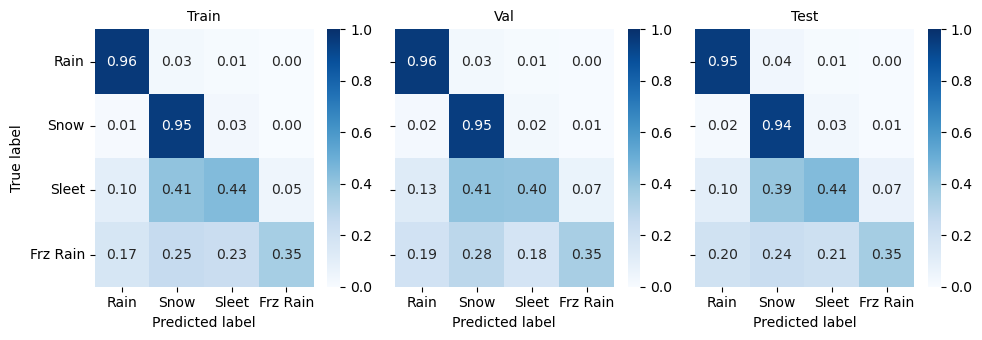

In [21]:
classes = ["Rain", "Snow", "Sleet", "Frz Rain"]
plot_confusion_matrix(data, classes, normalize='true')

In [22]:
from ptype.reliability import compute_calibration, reliability_diagrams
from collections import OrderedDict

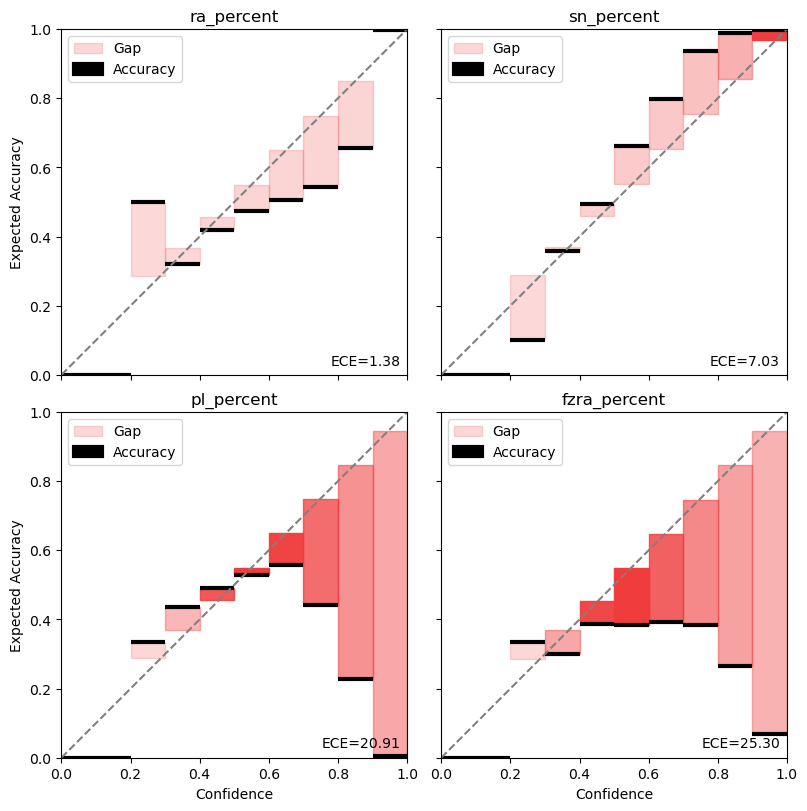

In [23]:
results = OrderedDict()
for label in range(len(output_features)):
    cond = data[name]["true_label"] == label
    results[output_features[label]] = {
        "true_labels": data[name][cond]["true_label"].values,
        "pred_labels": data[name][cond]["pred_label"].values,
        "confidences": data[name][cond]["pred_conf"].values,
    }
    results_calibration = compute_calibration(
        results[output_features[label]]["true_labels"],
        results[output_features[label]]["pred_labels"],
        results[output_features[label]]["confidences"],
        num_bins=10,
    )

_ = reliability_diagrams(
    results,
    num_bins=10,
    draw_bin_importance="alpha",
    num_cols=2,
    dpi=100,
    return_fig=True,
)

The end!